# Loading the data

In [1]:
# note the seprator in this file
import pandas as pd
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [ ]:
# pandas_profiling is an advanced/visual way of pd.describe() the complete html file is attached with the notebook

In [3]:
import pandas_profiling

In [4]:

pandas_profiling.ProfileReport(data)

### From the above profiling we can see that both gene and variation are very high cardinality and even class distribution is not uniform with class 8 in very low count

In [5]:
pfr = pandas_profiling.ProfileReport(data)
pfr.to_file("cancer_profiling.html")

# Now let's load the text and preprocess it 

In [149]:
# loading necessary libraries:

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
#warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [150]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = re.sub('\d+','',total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string
        
        
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")


#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 1059.6554539999925 seconds


In [6]:
result.to_pickle('cancer_merged.pckl')

In [159]:
result[result.isnull().any(axis = 1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [160]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [10]:
result.to_pickle('cancer_joined.pckl')

In [10]:
null_text_ids = [1109,1277,1407,1639,2755]

In [12]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2,random_state = 0)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2,random_state = 0)

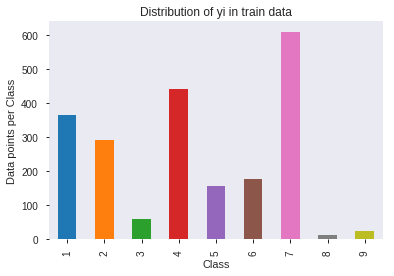

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


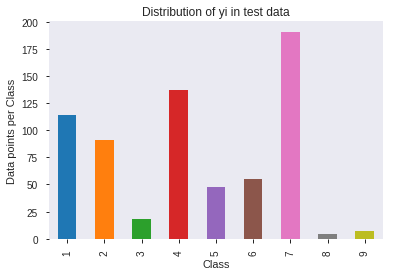

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


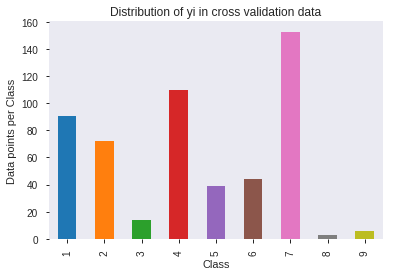

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [12]:
#let's recheck our y's distribution in train,test and validation set
# it returns a dict, keys as class labels and values as the number of data points in that class
%matplotlib inline
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


In [210]:
# prediction using random model

Log loss on Cross Validation Data using Random Model 2.5381712088967374
Log loss on Test Data using Random Model 2.4588521881684913
-------------------- Confusion matrix --------------------


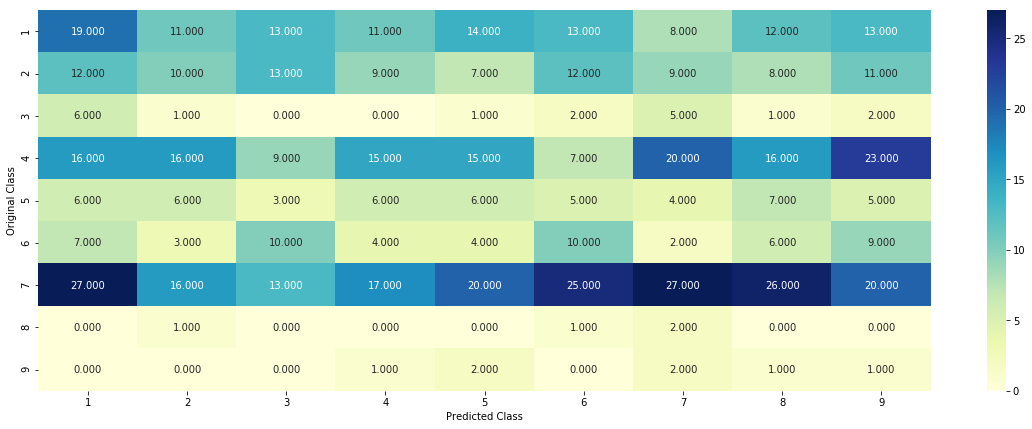

-------------------- Precision matrix (Columm Sum=1) --------------------


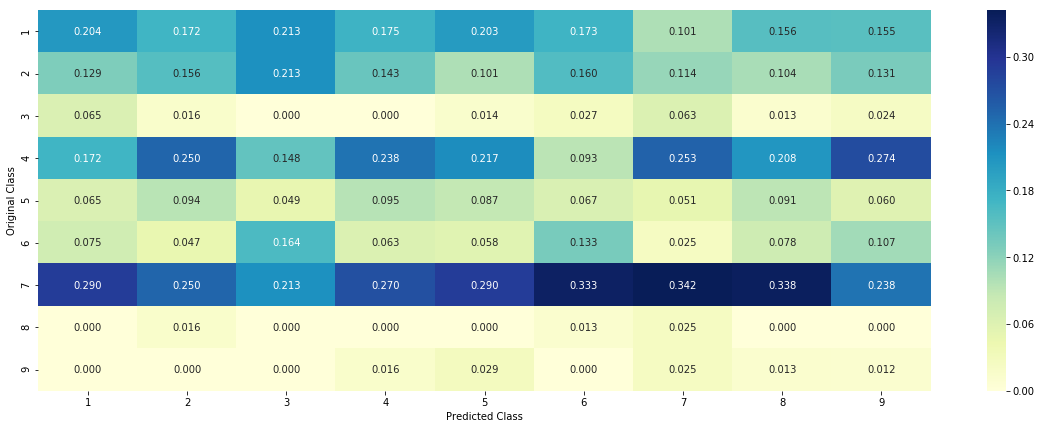

-------------------- Recall matrix (Row sum=1) --------------------


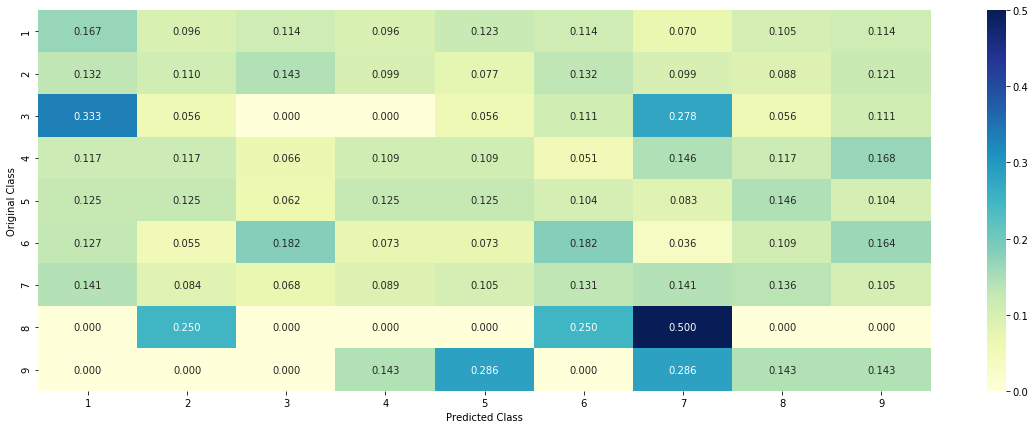

In [206]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

For values of alpha =  1e-05 The log loss is: 1.3870468447618116
For values of alpha =  0.0001 The log loss is: 1.2159741721811521
For values of alpha =  0.001 The log loss is: 1.240949911737416
For values of alpha =  0.01 The log loss is: 1.3471077827397941
For values of alpha =  0.1 The log loss is: 1.4655295368185326
For values of alpha =  1 The log loss is: 1.5070498610818233


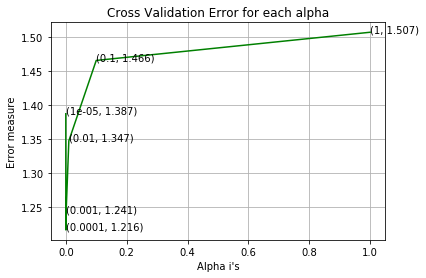

For values of best alpha =  0.0001 The train log loss is: 1.0505172190473848
For values of best alpha =  0.0001 The cross validation log loss is: 1.2159741721811521
For values of best alpha =  0.0001 The test log loss is: 1.1824833977922369


In [207]:
# Let's see how predictive is gene feature alone..
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.718318321949016
For values of alpha =  0.0001 The log loss is: 1.7055971679720234
For values of alpha =  0.001 The log loss is: 1.7031780233150435
For values of alpha =  0.01 The log loss is: 1.7097248043870965
For values of alpha =  0.1 The log loss is: 1.7163869593445384
For values of alpha =  1 The log loss is: 1.7192762227537037


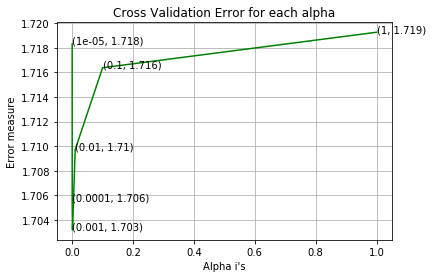

For values of best alpha =  0.001 The train log loss is: 1.068803879314989
For values of best alpha =  0.001 The cross validation log loss is: 1.7031780233150435
For values of best alpha =  0.001 The test log loss is: 1.708692905946978


In [208]:
alpha = [10 ** x for x in range(-5, 1)]

# lets' see how predictive variation feature alone


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### before we exploring ml models let's see how some dummy models fare

In [16]:
from sklearn.dummy import DummyClassifier


In [17]:
dmclf1 = DummyClassifier(strategy='uniform') #every class is pred with equal prob
dmclf2 = DummyClassifier(strategy='stratified')#respects the train-dist of classes

In [18]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [19]:
dmclf1.fit(train_gene_feature_onehotCoding,y_train)

DummyClassifier(constant=None, random_state=None, strategy='uniform')

In [20]:
y_pred = dmclf1.predict(test_gene_feature_onehotCoding)
accuracy_score(y_test,y_pred)

0.10977443609022557

In [21]:
dmclf2.fit(train_gene_feature_onehotCoding,y_train)
y_pred = dmclf2.predict(test_gene_feature_onehotCoding)
accuracy_score(y_test,y_pred)

0.18045112781954886

In [164]:
y_true = result.Class.values

In [209]:
# LET'S CREATE OUR TEXT FEATURES FOR FEEDING INTO BOOSTING LIBRARY - CATBOOST.Here i reduced the dimpensionality of 
#tfidf features to 500 using truncated svd.

In [165]:
x_train,x_test,train_y,test_y =  train_test_split(result, y_true, stratify=y_true, test_size=0.2,random_state = 0)

In [167]:
tf_text = TfidfVectorizer(max_features=30000,ngram_range=(1,2))
dm_red = TruncatedSVD(n_components=500)
tf_feat  = tf_text.fit_transform(x_train.TEXT.values)


In [168]:
red_trn_feat = dm_red.fit_transform(tf_feat)

In [169]:
red_trn_features = pd.DataFrame(red_trn_feat)

In [170]:
red_trn_features.index = x_train.index

In [171]:
trns_tst = tf_text.transform(x_test.TEXT.values)
red_tst_feat = dm_red.transform(trns_tst)
red_tst_features = pd.DataFrame(red_tst_feat)
red_tst_features.index = x_test.index

In [172]:
train = pd.concat([x_train,red_trn_features],axis = 1)

In [173]:
test = pd.concat([x_test,red_tst_features],axis = 1)

In [174]:
train = train.drop(['ID','Class','TEXT'],axis = 1)
test = test.drop(['ID','Class','TEXT'],axis = 1)

In [42]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

# The preprocessing done here are very clearly explained further in the notebook ... the necessary code for train_cats,apply_cats and other preprocessing utils is written couple of cells below - to not disturb the flow..ideally they should be written in seperate .py file but for compactness all the code is included here...

In [175]:
train_cats(train)


x,_,nas = proc_df(train)

# WHY CATBOOST:
* IT'S GPU VERSION IS 10 times faster than any other opensource libraries.
* They have out of the box support for categorical variables ... no need to encode(one-hot,response,..etc).How catboost handles categorical variables is a bit involved this talk by anna veronika explains all the detalis https://www.youtube.com/watch?v=oGRIGdsz7bM

In [68]:
%%time

model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'MultiClass'
})
categorical_features_indices = [0,1]
cv_data = cv(
    Pool(x, train_y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)#This performs 3 fold cross validation withreal time plotting....

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 7h 41min 46s, sys: 2min 8s, total: 7h 43min 55s
Wall time: 1h 6min 48s


In [64]:
cv_data.head(4)

test-MultiClass-mean  test-MultiClass-std  train-MultiClass-mean  \
0             -2.146001             0.001061              -2.149224   
1             -2.099778             0.001853              -2.105080   
2             -2.061687             0.002913              -2.068938   
3             -2.024011             0.005854              -2.032778   

   train-MultiClass-std  test-Accuracy-mean  test-Accuracy-std  \
0              0.001464            0.502256           0.008003   
1              0.002648            0.517689           0.015077   
2              0.006505            0.506397           0.009140   
3              0.003262            0.515050           0.025269   

   train-Accuracy-mean  train-Accuracy-std  
0             0.482300            0.019541  
1             0.496420            0.013006  
2             0.482676            0.020380  
3             0.495293            0.003958

In [65]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.67±0.03 on step 791


In [186]:
print('Best validation MultiClass score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-MultiClass-mean']),
    cv_data['test-MultiClass-std'][np.argmax(cv_data['test-MultiClass-mean'])],
    np.argmax(cv_data['test-MultiClass-mean'])
))

Best validation MultiClass score: -0.96±0.07 on step 999


In [176]:
apply_cats(test,train)

In [177]:
test_x,_,nas = proc_df(test)

In [73]:
test_x.head(2)

Gene  Variation         0         1         2         3         4  \
2017   129          0  0.184858 -0.166214 -0.055469 -0.100621 -0.065595   
1337   122        123  0.098816 -0.062659 -0.019665 -0.062846 -0.004196   

             5         6         7    ...          490       491       492  \
2017 -0.061469  0.023185 -0.172506    ...    -0.030161 -0.022932 -0.024715   
1337 -0.006478  0.013719 -0.017400    ...     0.006856  0.007441  0.005504   

           493       494       495       496       497       498       499  
2017 -0.007018 -0.012012  0.007700 -0.004543 -0.005935  0.004859 -0.036733  
1337  0.001445 -0.001515  0.004143  0.001231 -0.012445  0.009979 -0.016878  

[2 rows x 502 columns]

In [76]:
%%time
#let's do early stopping
# this prevents overfitting and also faster training ... this is the final model we will be using.
earlystop_params = cv_params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(Pool(x, train_y, cat_features=categorical_features_indices))

CPU times: user 2h 38min 40s, sys: 32.3 s, total: 2h 39min 12s
Wall time: 20min 18s


In [77]:
earlystop_model.best_score_

{'learn': {'Accuracy': 0.8343373493975904, 'MultiClass': -0.5693213850524157}}

# LET'S CHECK THE LOGLOSS OF OUR MODEL ON OUR TEST DATASET......

In [78]:
probs = earlystop_model.predict_proba(test_x)

In [80]:
probs.shape

(665, 9)

In [81]:
#log loss
from sklearn.metrics import log_loss

In [84]:
y_true = np.zeros(probs.shape)

In [85]:
y_true[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [86]:
for id,val in enumerate(test_y.tolist()):
    y_true[id,val-1] = 1

In [87]:
log_loss(y_true,probs)  # That's our score on test set ..............

0.8976375693384264

# LET'S LOOK AT THE IMPORTANT FEATURES..

In [93]:
feat_imp = pd.DataFrame(earlystop_model.feature_names_,index=earlystop_model.feature_importances_)

In [98]:
feat_imp.sort_index(inplace=True,ascending=False)
feat_imp.head(10)

0
26.254487       Gene
3.316072           1
2.728233           2
2.611347   Variation
2.155429           4
1.247175           0
0.734630           8
0.700930          25
0.696308          49
0.663081          26

In [187]:
model_select['Catboost'] = {'clf':earlystop_model,
                       'best_testloss':0.89}

# let's see how random - forest model fares with our numerical encoding..

In [180]:
len(x),len(train_y),len(test_x),len(test_y)

(2656, 2656, 665, 665)

In [179]:
trn_x,crsvl_x,trn_y,crsvl_y = train_test_split(x,train_y,test_size = 0.2)

In [184]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(trn_x, trn_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(trn_x, trn_y)
        sig_clf_probs = sig_clf.predict_proba(crsvl_x)
        cv_log_error_array.append(log_loss(crsvl_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(crsvl_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(trn_x, trn_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(trn_x, trn_y)

predict_y = sig_clf.predict_proba(trn_x)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(trn_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(crsvl_x)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(crsvl_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.5079718309192816
for n_estimators = 10 and max depth =  3
Log Loss : 1.4077183654669738
for n_estimators = 10 and max depth =  5
Log Loss : 1.3144679829812451
for n_estimators = 10 and max depth =  10
Log Loss : 1.232368274321989
for n_estimators = 50 and max depth =  2
Log Loss : 1.401505931599722
for n_estimators = 50 and max depth =  3
Log Loss : 1.324044821844658
for n_estimators = 50 and max depth =  5
Log Loss : 1.2285096029184963
for n_estimators = 50 and max depth =  10
Log Loss : 1.158725547390799
for n_estimators = 100 and max depth =  2
Log Loss : 1.3879121225404658
for n_estimators = 100 and max depth =  3
Log Loss : 1.3244444166671259
for n_estimators = 100 and max depth =  5
Log Loss : 1.2189458683403624
for n_estimators = 100 and max depth =  10
Log Loss : 1.146291451827244
for n_estimators = 200 and max depth =  2
Log Loss : 1.387358136136437
for n_estimators = 200 and max depth =  3
Log Loss : 1.3200299646382485
for

In [185]:
model_select['RandomForest_numerical_feat'] = {'clf':clf,'best_trainloss':0.55,
                       'best_crossvalloss':1.14,
                       'best_testloss':1.1}

In [49]:
# some utility functions these are not required for modern boosting libraries like catboost but nedded for 
#random forest...i'am not sure if i want to try random forests here but neverthless....but for handling edge cases 
#like presence of new categories in test set or none values...


#from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.

    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.

    Examples:
    ---------

    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
            
            
def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.

    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.

    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category {a : 1, b : 2}

    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)

           col1 col2
        0     1    b
        1     2    a
        2     3    a

    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


            
            
            
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.

    Parameters:
    -----------
    df: The data frame that will be changed.

    col: The column of data to fix by filling in missing data.

    name: The name of the new filled column in df.

    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.


    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]
    return DataFrameMapper(cat_maps).fit(df), DataFrameMapper(contin_maps).fit(df)
    


def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper






def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> numericalize(df, df['col2'], 'col3', None)

       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1
            

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    ignore_flds: A list of fields that are ignored during processing.

    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> x, y, nas = proc_df(df, 'col1')
    >>> x

       col2
    0     1
    1     2
    2     1

    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])

    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])

    >>>round(fit_transform!(mapper, copy(data)), 2)

    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)   
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [100]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

# FEATURIZING VARIATION FEATURE

In [110]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))






# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

# FEATURIZING GENE 

In [102]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [111]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

# FEATURIZING TEXT

In [103]:
%%time
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(ngram_range=(1,2),max_features=30000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 30000
CPU times: user 22.4 s, sys: 359 ms, total: 22.8 s
Wall time: 22.2 s


In [104]:
%%time
# building a TFIDFVECTORIZER KEEPING ONLY TOP 1000 FEATURES...
text_vectorizer = TfidfVectorizer(min_df=3,max_features=1000)
train_text_feature_tfidfCoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_tfidfCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000
CPU times: user 6.41 s, sys: 8.04 ms, total: 6.41 s
Wall time: 6.44 s


In [105]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [106]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [107]:
# NORMALIZING EACH ROW....
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [108]:
# don't forget to normalize every feature
train_text_feature_tdfidCoding = normalize(train_text_feature_tfidfCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidfCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_tfidfCoding = normalize(test_text_feature_tfidfCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidfCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidfCoding = normalize(cv_text_feature_tfidfCoding, axis=0)

In [112]:
# now let's get all the features in place:

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_tfidfCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_tfidfCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidfCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [32]:
result['TEXT'].head(2)

0    cyclin dependent kinases cdks regulate variety...
1    abstract background non small cell lung cancer...
Name: TEXT, dtype: object

In [113]:
sentences = []
for text in result['TEXT']:
    sentences.append(text.split())

In [34]:
len(sentences)

3321

# Data preparation / #Misc. functionns  for ML models.

In [122]:



# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)


# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

for alpha = 1e-05
Log Loss : 1.190570603868347
for alpha = 0.0001
Log Loss : 1.190139684988732
for alpha = 0.001
Log Loss : 1.189739758312866
for alpha = 0.1
Log Loss : 1.1952808546189746
for alpha = 1
Log Loss : 1.2431607785143655
for alpha = 10
Log Loss : 1.2782721652441469
for alpha = 100
Log Loss : 1.3032935296600257
for alpha = 1000
Log Loss : 1.310240860452855


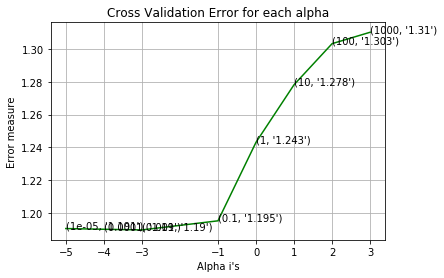

For values of best alpha =  0.001 The train log loss is: 0.5500565571277997
For values of best alpha =  0.001 The cross validation log loss is: 1.189739758312866
For values of best alpha =  0.001 The test log loss is: 1.1687438585319325


In [114]:
# Running MULTINOMIALNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [116]:
# let's save it for future reference
model_select = {}
model_select['MultinomialNB'] = {'clf':clf,'best_trainloss':0.55,'best_crossvalloss':1.18,'best_testloss':1.16}

In [119]:
from sklearn.externals import joblib

In [120]:
joblib.dump(clf,'MulNB_cancer.joblib')

['MulNB_cancer.joblib']

Log Loss : 1.189739758312866
Number of missclassified point : 0.37406015037593987
-------------------- Confusion matrix --------------------


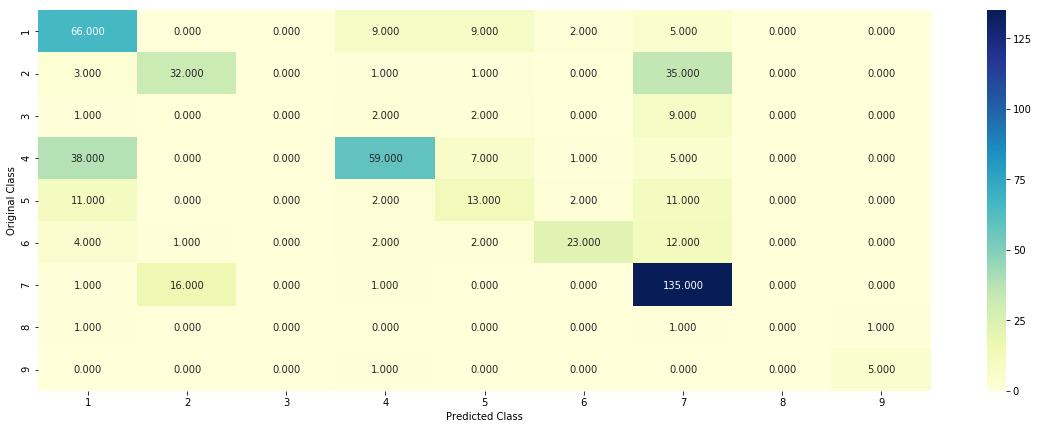

-------------------- Precision matrix (Columm Sum=1) --------------------


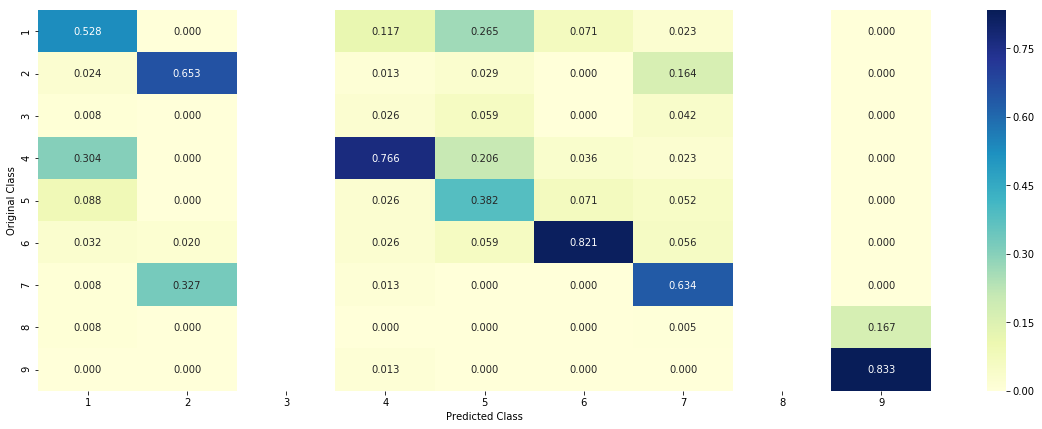

-------------------- Recall matrix (Row sum=1) --------------------


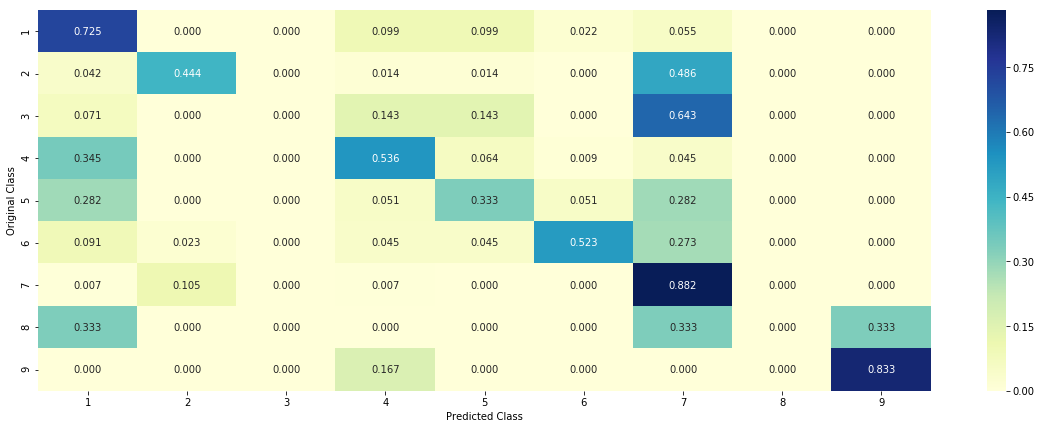

In [123]:
# ----------------------------

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [124]:
#feat importance of correctly classifed point

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1127 0.2515 0.0176 0.0926 0.0416 0.0775 0.4001 0.004  0.0025]]
Actual Class : 6
--------------------------------------------------
7 Text feature [addition] present in test data point [True]
36 Text feature [accounts] present in test data point [True]
45 Text feature [ag] present in test data point [True]
54 Text feature [action] present in test data point [True]
61 Text feature [adjacent] present in test data point [True]
95 Text feature [aberrant] present in test data point [True]
Out of the top  100  features  6 are present in query point


In [125]:
#feat imp of incorrectly classifed point
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 4
Predicted Class Probabilities: [[0.291  0.044  0.0145 0.4801 0.0343 0.0353 0.0952 0.0034 0.0021]]
Actual Class : 1
--------------------------------------------------
28 Text feature [aberrant] present in test data point [True]
38 Text feature [acquire] present in test data point [True]
81 Text feature [addition] present in test data point [True]
88 Text feature [activating] present in test data point [True]
91 Text feature [abbreviations] present in test data point [True]
Out of the top  100  features  5 are present in query point


for alpha = 5
Log Loss : 1.0528074978561501
for alpha = 11
Log Loss : 1.0525829676190555
for alpha = 15
Log Loss : 1.0544401895143247
for alpha = 21
Log Loss : 1.0714506368177135
for alpha = 31
Log Loss : 1.0685566591636724
for alpha = 41
Log Loss : 1.0618017392491668
for alpha = 51
Log Loss : 1.0721599392393188
for alpha = 99
Log Loss : 1.1062067981180885


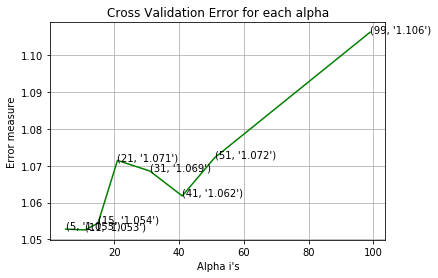

For values of best alpha =  11 The train log loss is: 0.6508949575274756
For values of best alpha =  11 The cross validation log loss is: 1.0525829676190555
For values of best alpha =  11 The test log loss is: 1.047257030707696


In [127]:
# Lets' run knn

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [130]:
model_select['Knn'] = {'clf':clf,'best_trainloss':0.65,
                       'best_crossvalloss':1.05,
                       'best_testloss':1.04}

Log loss : 1.0525829676190555
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


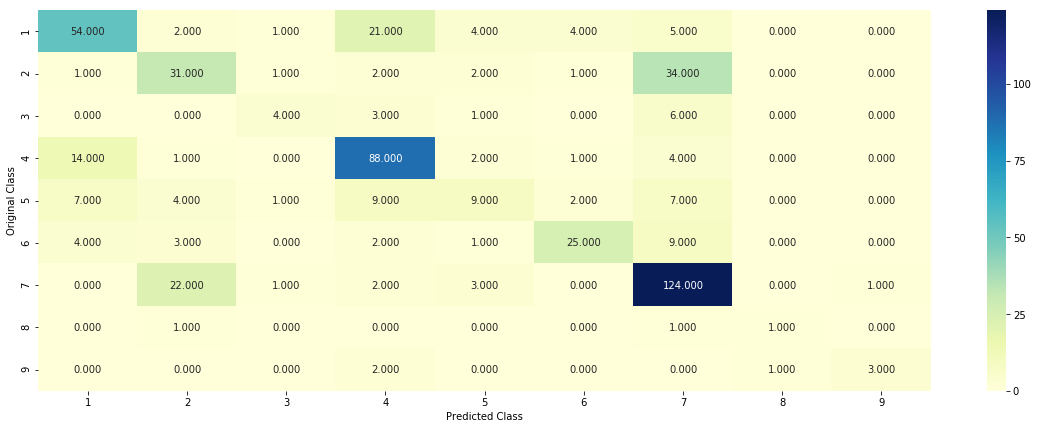

-------------------- Precision matrix (Columm Sum=1) --------------------


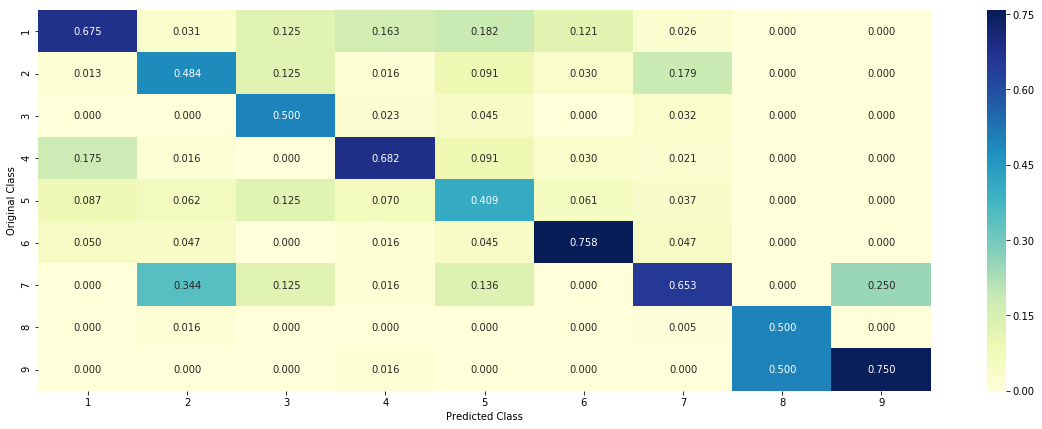

-------------------- Recall matrix (Row sum=1) --------------------


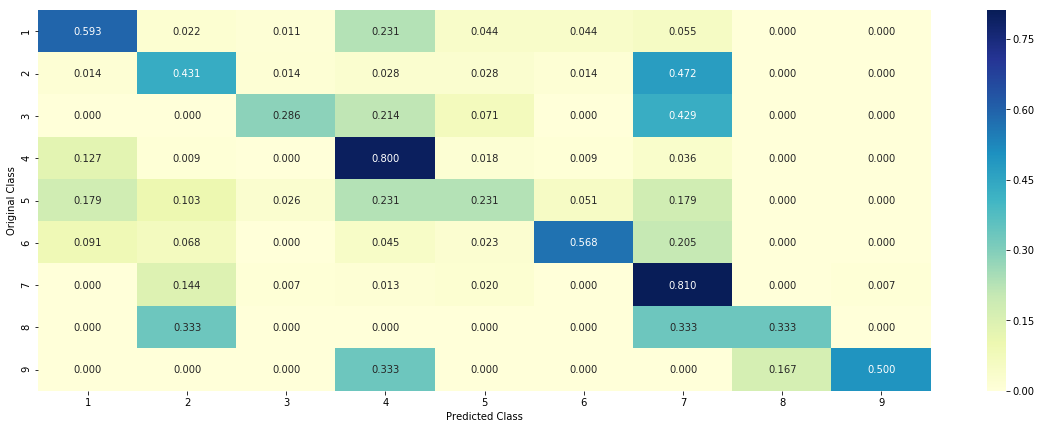

In [131]:
# testing wit best hyperparmeters

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [132]:
%%time
#building countvectorizer with ngram.. for logistic regression...
text_vectorizer = CountVectorizer(min_df=3,ngram_range=(1,2))
train_text_feature_bowCoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features_bow= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_bowCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features_bow),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features_bow))



# don't forget to normalize every feature
train_text_feature_bowCoding = normalize(train_text_feature_bowCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_bowCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_bowCoding = normalize(test_text_feature_bowCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_bowCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidfCoding = normalize(cv_text_feature_bowCoding, axis=0)


# now let's get all the features in place:

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_tbow = hstack((train_gene_var_onehotCoding, train_text_feature_bowCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding_tbow = hstack((test_gene_var_onehotCoding, test_text_feature_bowCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding_tbow = hstack((cv_gene_var_onehotCoding, cv_text_feature_bowCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))



Total number of unique words in train data : 677623
CPU times: user 41.6 s, sys: 961 ms, total: 42.6 s
Wall time: 37.6 s


for alpha = 1e-06
Log Loss : 2.2908002010593647
for alpha = 1e-05
Log Loss : 2.372574056010034
for alpha = 0.0001
Log Loss : 2.314564583385847
for alpha = 0.001
Log Loss : 2.6435874360462535
for alpha = 0.01
Log Loss : 17.459126876241424
for alpha = 0.1
Log Loss : 11.204020470980803
for alpha = 1
Log Loss : 6.644283028439167
for alpha = 10
Log Loss : 13.450997493369576
for alpha = 100
Log Loss : 16.214908210383943


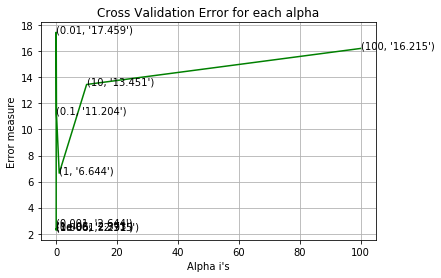

For values of best alpha =  1e-06 The train log loss is: 1.365469196447641
For values of best alpha =  1e-06 The cross validation log loss is: 2.2908002010593647
For values of best alpha =  1e-06 The test log loss is: 1.5951467944974578


In [134]:
# logistic regression with class balancing


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_tbow, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tbow, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tbow)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_tbow, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tbow, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_tbow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tbow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tbow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [136]:
model_select['LogisticRegression_bow'] = {'clf':clf,'best_trainloss':1.36,
                       'best_crossvalloss':2.29,
                       'best_testloss':1.59}

Log loss : 2.2908002010593647
Number of mis-classified points : 0.5526315789473685
-------------------- Confusion matrix --------------------


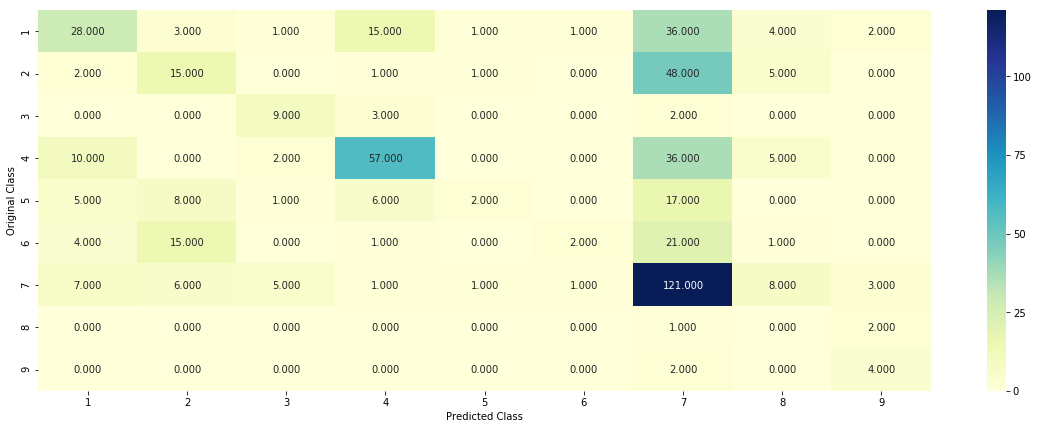

-------------------- Precision matrix (Columm Sum=1) --------------------


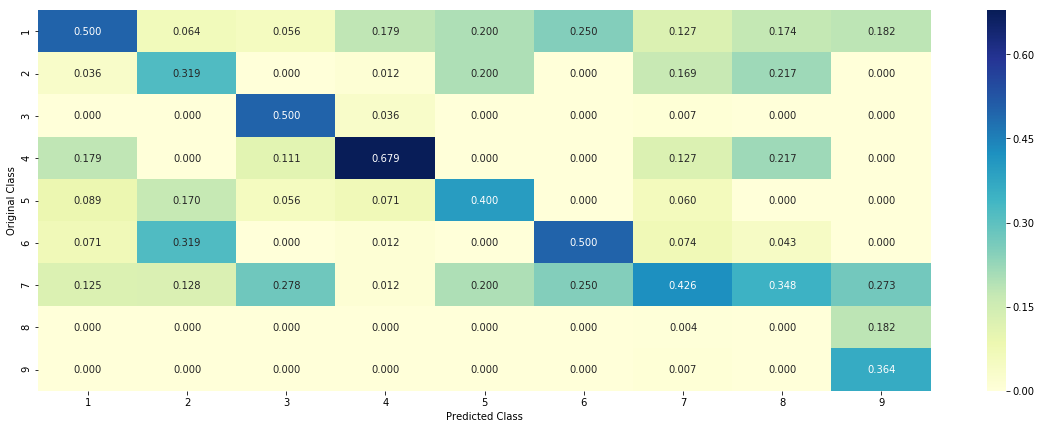

-------------------- Recall matrix (Row sum=1) --------------------


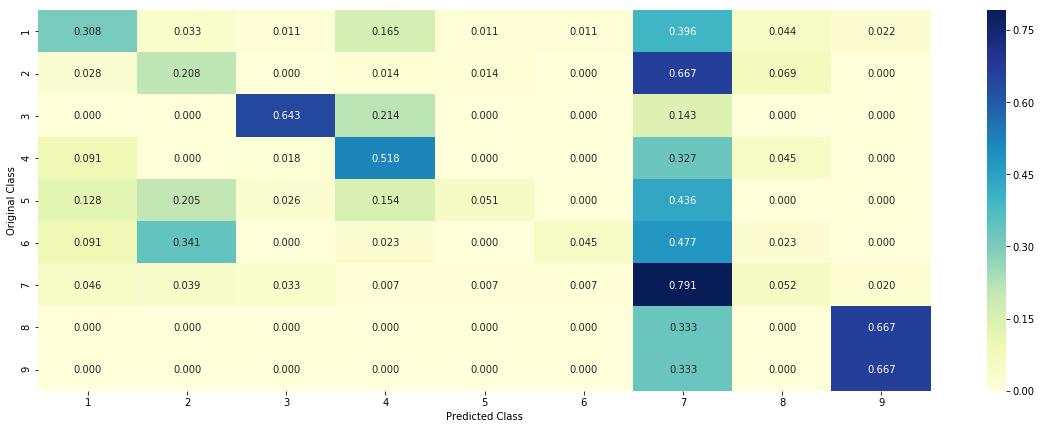

In [135]:
# TESTING THE MODEL WITH BEST HYPERPARAMETERS
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_tbow, train_y, cv_x_onehotCoding_tbow, cv_y, clf)

for C = 1e-05
Log Loss : 1.1675617873407982
for C = 0.0001
Log Loss : 1.123833844938794
for C = 0.001
Log Loss : 1.1368971905685115
for C = 0.01
Log Loss : 1.3067851686174792
for C = 0.1
Log Loss : 1.5555954513041497
for C = 1
Log Loss : 1.6314246872863822
for C = 10
Log Loss : 1.631424698179594
for C = 100
Log Loss : 1.631424703710667


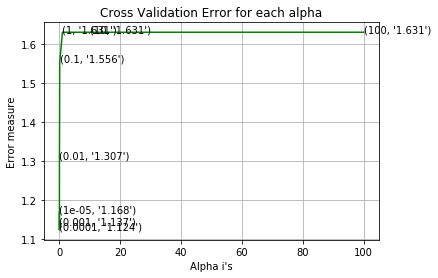

For values of best alpha =  0.0001 The train log loss is: 0.5047088984284458
For values of best alpha =  0.0001 The cross validation log loss is: 1.123833844938794
For values of best alpha =  0.0001 The test log loss is: 1.105109041880133


In [139]:
# linear svm


alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [140]:
model_select['Linear_svm'] = {'clf':clf,'best_trainloss':0.504,
                       'best_crossvalloss':1.12,
                       'best_testloss':1.1}

Log loss : 1.123833844938794
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


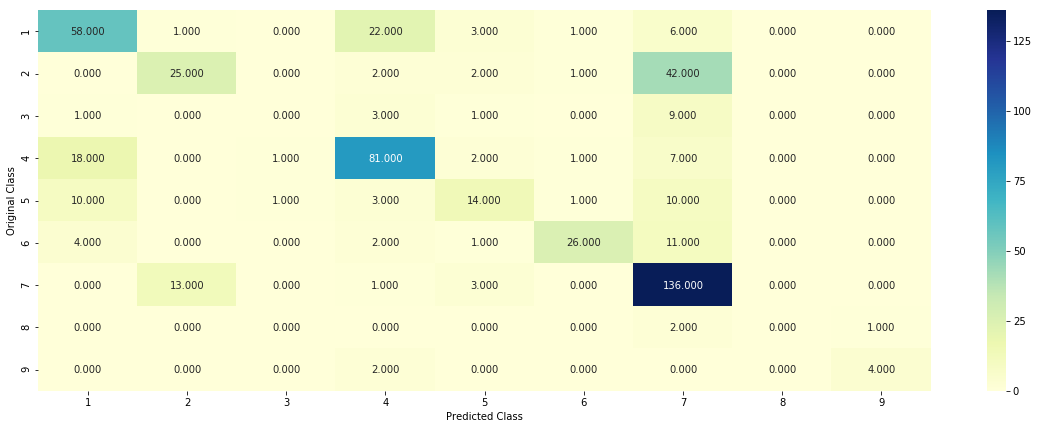

-------------------- Precision matrix (Columm Sum=1) --------------------


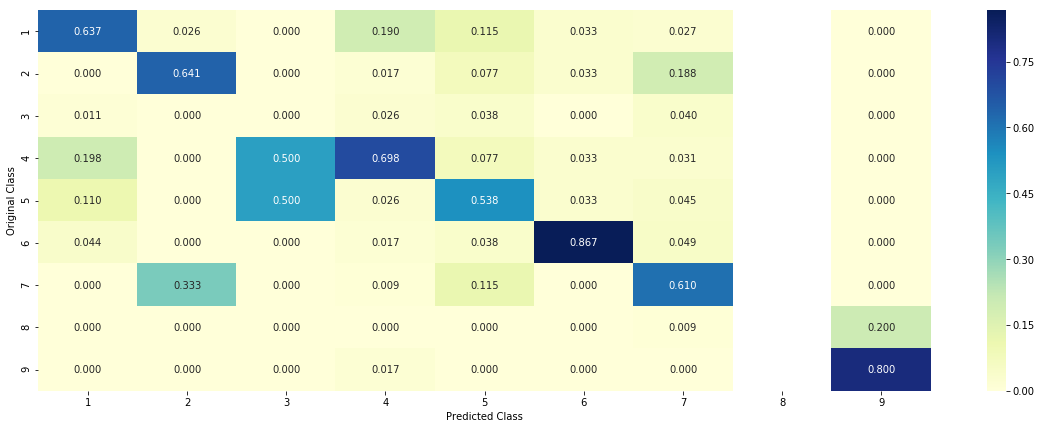

-------------------- Recall matrix (Row sum=1) --------------------


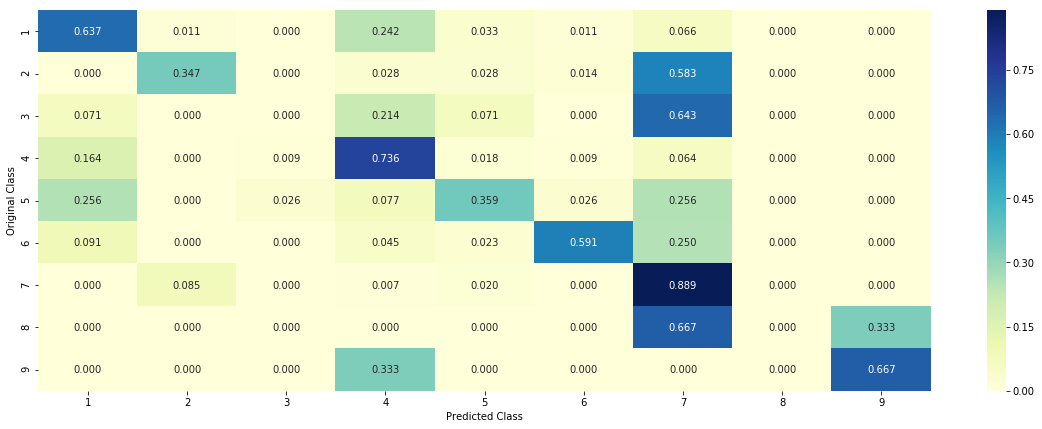

In [141]:
# Testing Model with best Hyperparmeters

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [142]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0312 0.3467 0.0138 0.024  0.021  0.2906 0.2662 0.0043 0.0023]]
Actual Class : 6
--------------------------------------------------
108 Text feature [affecting] present in test data point [True]
115 Text feature [abolished] present in test data point [True]
228 Text feature [adults] present in test data point [True]
243 Text feature [activates] present in test data point [True]
256 Text feature [adjacent] present in test data point [True]
343 Text feature [according] present in test data point [True]
347 Text feature [additionally] present in test data point [True]
366 Text feature [activating] present in test data point [True]
381 Text feature [activated] present in test data point [True]
386 Text feature [aberrant] present in test data point [True]
393 Text feature [acids] present in test data point [True]
436 Text feature [abi] present in test data point [True]
441 Text feature [absence] present in test data point [True]
445 Text

In [143]:
# for incorrectly classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2522 0.025  0.0127 0.6169 0.0471 0.0106 0.0306 0.0029 0.002 ]]
Actual Class : 1
--------------------------------------------------
200 Text feature [absence] present in test data point [True]
206 Text feature [actual] present in test data point [True]
209 Text feature [activating] present in test data point [True]
235 Text feature [addition] present in test data point [True]
437 Text feature [activation] present in test data point [True]
460 Text feature [aim] present in test data point [True]
485 Text feature [adenoviruses] present in test data point [True]
Out of the top  500  features  7 are present in query point


In [144]:
# Testing the model wih random forests

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2668445661488998
for n_estimators = 100 and max depth =  10
Log Loss : 1.3522566469391437
for n_estimators = 200 and max depth =  5
Log Loss : 1.2506520272486152
for n_estimators = 200 and max depth =  10
Log Loss : 1.3458427127162533
for n_estimators = 500 and max depth =  5
Log Loss : 1.2459309245202552
for n_estimators = 500 and max depth =  10
Log Loss : 1.3423122014252893
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2461331373323437
for n_estimators = 1000 and max depth =  10
Log Loss : 1.3416553103394477
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2433703221750663
for n_estimators = 2000 and max depth =  10
Log Loss : 1.3368553809925992
For values of best estimator =  2000 The train log loss is: 0.8515669011187808
For values of best estimator =  2000 The cross validation log loss is: 1.2433703221750663
For values of best estimator =  2000 The test log loss is: 1.195439259761051


In [145]:
model_select['RandomForest'] = {'clf':clf,'best_trainloss':0.85,
                       'best_crossvalloss':1.24,
                       'best_testloss':1.19}

Log loss : 1.2433703221750663
Number of mis-classified points : 0.4473684210526316
-------------------- Confusion matrix --------------------


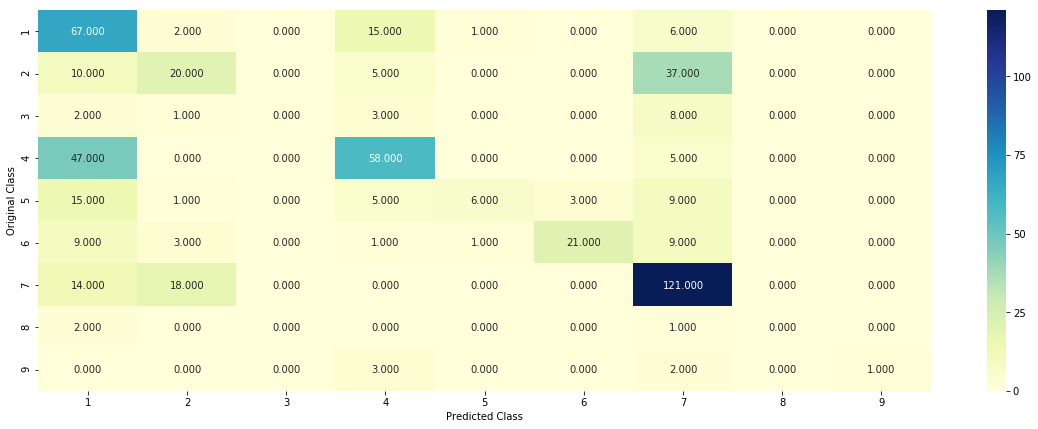

-------------------- Precision matrix (Columm Sum=1) --------------------


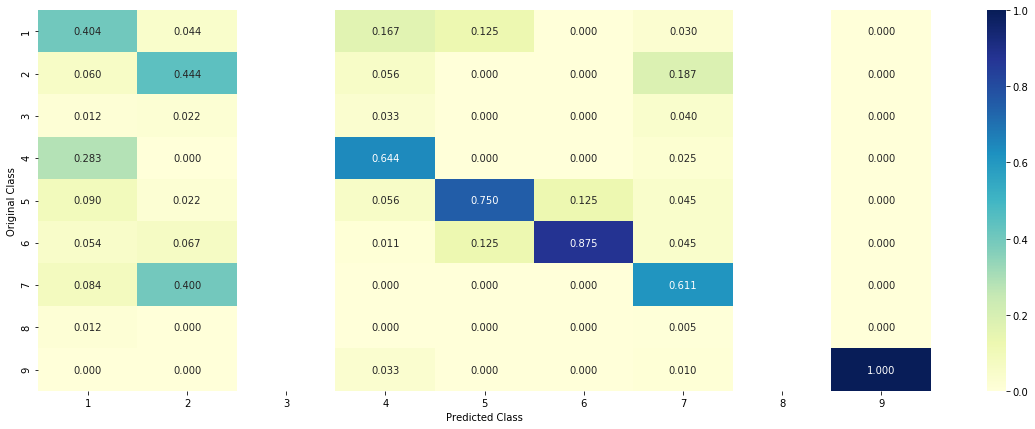

-------------------- Recall matrix (Row sum=1) --------------------


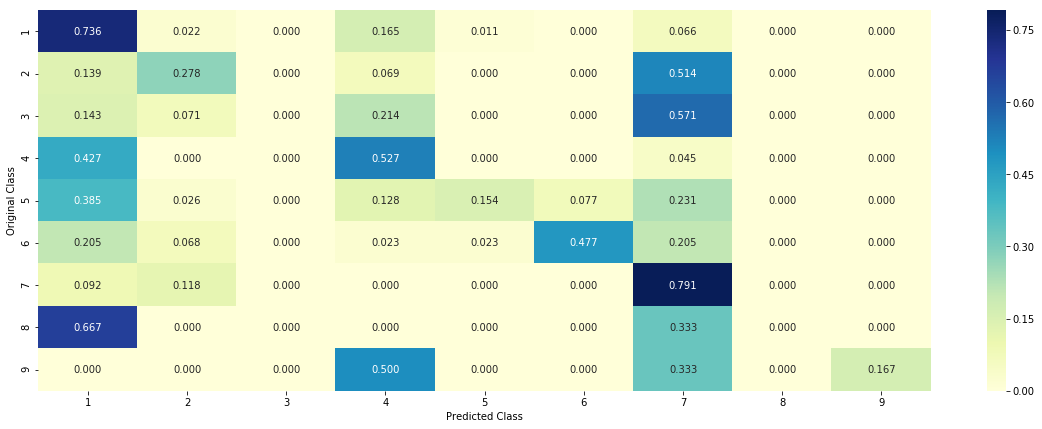

In [146]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [147]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.113265902658929
for n_estimators = 10 and max depth =  3
Log Loss : 1.6854584261044396
for n_estimators = 10 and max depth =  5
Log Loss : 1.418245343907731
for n_estimators = 10 and max depth =  10
Log Loss : 2.0213542287066644
for n_estimators = 50 and max depth =  2
Log Loss : 1.6909587433907678
for n_estimators = 50 and max depth =  3
Log Loss : 1.3641619757138648
for n_estimators = 50 and max depth =  5
Log Loss : 1.315579671909442
for n_estimators = 50 and max depth =  10
Log Loss : 1.5407226797474203
for n_estimators = 100 and max depth =  2
Log Loss : 1.5109746096302648
for n_estimators = 100 and max depth =  3
Log Loss : 1.4267748790564143
for n_estimators = 100 and max depth =  5
Log Loss : 1.2617624643431193
for n_estimators = 100 and max depth =  10
Log Loss : 1.6332173500253797
for n_estimators = 200 and max depth =  2
Log Loss : 1.527125975618462
for n_estimators = 200 and max depth =  3
Log Loss : 1.42264384546462
for

In [151]:
# let's use a stacking classifier and  see how it fares...


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.63
Naive Bayes : Log Loss: 1.19
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.037
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.525
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.171
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.364
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.780


Log loss (train) on the stacking classifier : 0.5654865665846661
Log loss (CV) on the stacking classifier : 1.1705759068927022
Log loss (test) on the stacking classifier : 1.1499043022345614
Number of missclassified point : 0.37593984962406013
-------------------- Confusion matrix --------------------


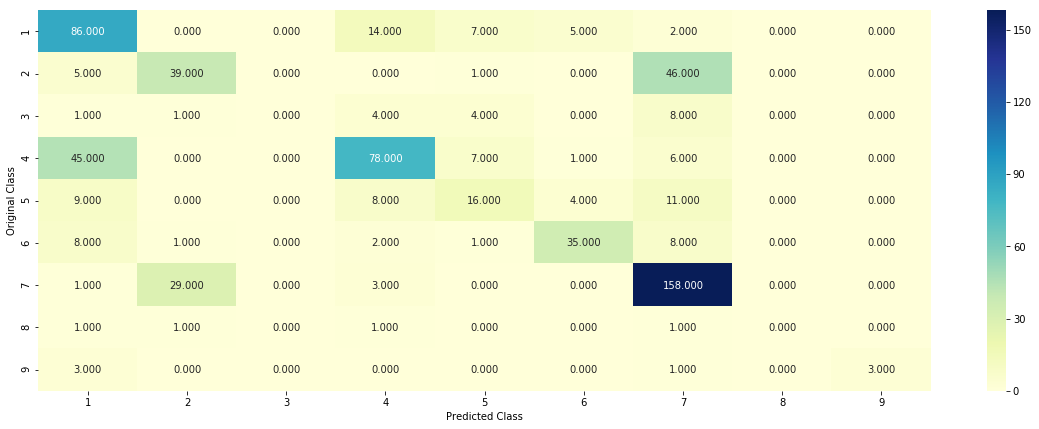

-------------------- Precision matrix (Columm Sum=1) --------------------


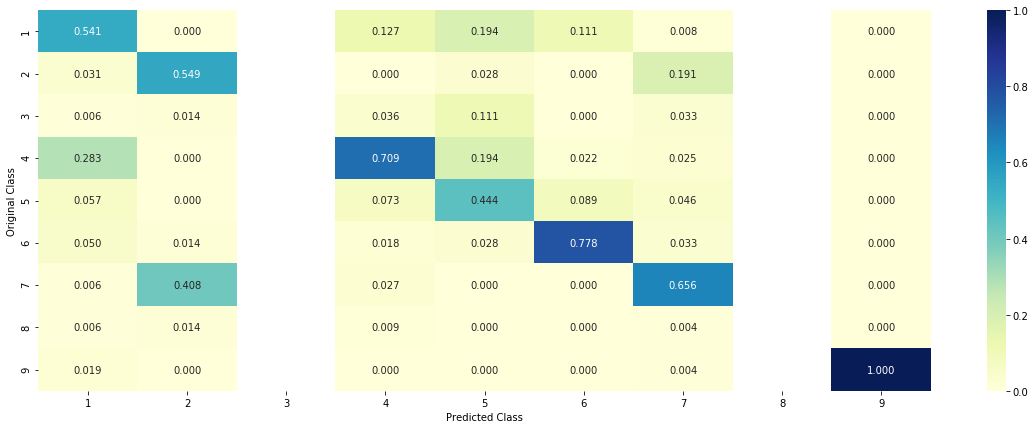

-------------------- Recall matrix (Row sum=1) --------------------


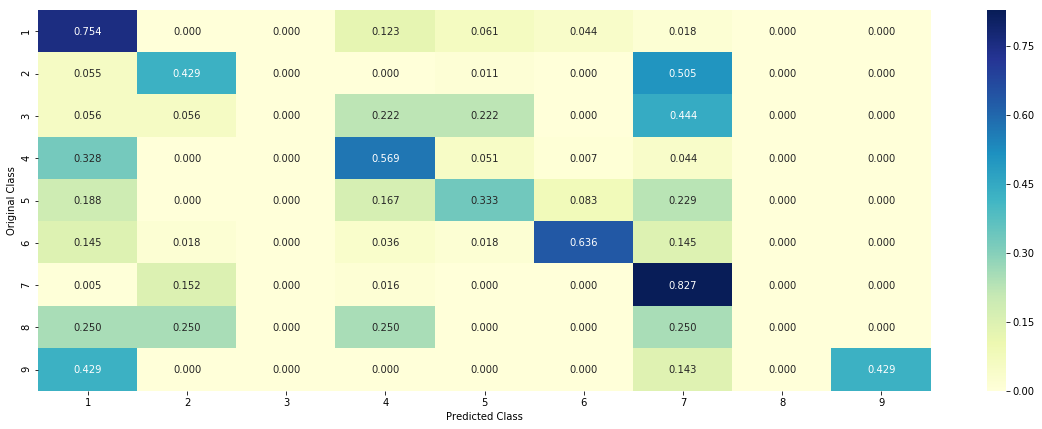

In [152]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [205]:

for key in model_select:
    print('----------------------------------------------------\n')
    print(key)
    
    for ky,vl in model_select[key].items():
        print('{}    {}\n'.format(ky,vl) )
    

----------------------------------------------------

MultinomialNB
clf    MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

best_trainloss    0.55

best_crossvalloss    1.18

best_testloss    1.16

----------------------------------------------------

Knn
clf    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

best_trainloss    0.65

best_crossvalloss    1.05

best_testloss    1.04

----------------------------------------------------

LogisticRegression_bow
clf    SGDClassifier(alpha=1e-06, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

best_trainloss    1.36

best_crossvalloss    2.29

best_testloss    1.59



# Now let's see if we could use a deep learning based end-end model ..... 

In [35]:
len_sent = pd.Series([len(sent) for sent in sentences])
len_sent.describe()

count     3321.000000
mean      6129.623306
std       5032.777526
min          2.000000
25%       3068.000000
50%       4411.000000
75%       7643.000000
max      50878.000000
dtype: float64

In [36]:
# let's also get word2vec features:


from gensim.models import Word2Vec

In [37]:
%time model = Word2Vec(sentences,min_count = 1,size = 300)

CPU times: user 4min 42s, sys: 852 ms, total: 4min 42s
Wall time: 1min 39s


In [38]:
# summarize the loaded model
print(model)
# summarize vocabulary

Word2Vec(vocab=92926, size=300, alpha=0.025)


In [39]:
words = list(model.wv.vocab)
print(words[:5])

['cyclin', 'dependent', 'kinases', 'cdks', 'regulate']


In [40]:
# access vector for one word
print(model['dependent'])
# save model

[ 1.37832427e+00 -1.98064506e+00  4.74764369e-02  2.78076828e-01
  2.25879407e+00 -2.19037771e+00  1.82151628e+00  3.13830674e-01
 -1.24210155e+00  5.55441976e-01 -2.36216009e-01  8.88516366e-01
 -1.02471995e+00 -6.12287700e-01 -3.10989022e+00  1.58387852e+00
 -2.92394185e+00  3.21354151e-01  6.14279866e-01  5.69117129e-01
 -9.33241427e-01 -8.34923029e-01 -3.18450034e-01  1.45424396e-01
  3.61798286e-01  1.24573433e+00  3.57065916e-01 -2.43364620e+00
  1.25030649e+00 -1.25364780e+00 -7.37692893e-01 -1.84016120e+00
  3.24087776e-03  2.35770226e+00  6.74792588e-01 -5.42318344e-01
  1.52247563e-01 -3.61410093e+00 -2.92689490e+00  2.01698017e+00
  1.91938376e+00 -7.95852005e-01  1.05274713e+00  1.68906426e+00
  1.40089762e+00 -2.39924169e+00 -1.20061266e+00 -3.75230312e-01
 -8.62162769e-01 -1.05364943e+00  3.13176252e-02 -9.05674279e-01
 -1.25747645e+00  1.31052220e+00  7.91718066e-01  2.99438924e-01
  4.18685079e-01  2.18574142e+00  2.55949163e+00 -1.82802582e+00
 -1.91440001e-01 -2.83442

In [41]:
model.save('cancer_w2v.bin')
# # load model
# new_model = Word2Vec.load('model.bin')
# print(new_model)

In [42]:
model.most_similar('dependent')

[('dependently', 0.5271409749984741),
 ('mediated', 0.4554774761199951),
 ('controllable', 0.42472440004348755),
 ('stimulates', 0.4163050651550293),
 ('dosedependent', 0.3994300961494446),
 ('dependence', 0.3969881534576416),
 ('depend', 0.3957718014717102),
 ('radioprotective', 0.38892650604248047),
 ('activates', 0.3785581588745117),
 ('regulated', 0.3780234456062317)]

In [43]:
result['TEXT'].iloc[null_text_ids]

1109                   FANCA S1088F
1277    ARID5B Truncating Mutations
1407                    FGFR3 K508M
1639             FLT1 Amplification
2755                     BRAF G596C
Name: TEXT, dtype: object

In [44]:
data_text.head(5)

ID                                               TEXT
0   0  cyclin dependent kinases cdks regulate variety...
1   1  abstract background non small cell lung cancer...
2   2  abstract background non small cell lung cancer...
3   3  recent evidence demonstrated acquired uniparen...
4   4  oncogenic mutations monomeric casitas b lineag...

In [45]:
result.head(2)

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating_Mutations      1   
1   1     CBL                 W802*      2   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...

In [199]:
# previously for our machine learnig models we have imputed blank text with 'variation + class' ... now lets' undo it
#as that would increase the diff between max(len(text)) and min(len(text)).

In [46]:
text_ids = set(range(len(result)))- set(null_text_ids)

In [47]:
text_ids = [x for x in text_ids]

In [48]:
x = result[['TEXT']].iloc[text_ids,:]

In [49]:
y = result[['Class']].iloc[text_ids,:]

## here we will use only text data to predict outcomes....

In [50]:
from preprocessing.utils import Preprocess, remove_empty_docs

from model.cnn_document_model import DocumentModel, TrainingParameters
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from keras.utils import to_categorical
import keras.backend as K

Using TensorFlow backend.


# THE PREPROCESSING UTILS AND THE MODEL ITSELF IS IMPLEMENTED AS PYTHON MODULE...BUT I WOULD INCLUDE THE CODE DETAILS BELOW.....BUT BEFORE THAT LET'S LOOK AT THE MODEL 

# THE FOLLOWING IS THE IMPLEMETATION OF CNN DOCUMENT MODEL:https://arxiv.org/pdf/1406.3830.pdf

<img src = 'DM.png'>

# Here we are using cnn model but one interesting idea is K-max pooling(instead of max-pooling where we take max of the elements ...here we will choose only k highest elements from the dimension... )..look at the code below or the paper for further details..

In [51]:
Preprocess.MIN_WD_COUNT=5
Preprocess.SENTENCE_LEN = 30
Preprocess.NUM_SENTENCES = 40

In [52]:

x_trn,x_tst,y_trn,y_tst = train_test_split(x, y, stratify=y, test_size=0.2)

In [54]:
x_trn = x_trn.values
x_trn.shape

(2652, 1)

In [55]:
x_tst = x_tst.values

In [56]:
x_tst = x_tst.tolist()

In [57]:
x_trn = x_trn.tolist()

In [58]:
x_trn = [doc[0] for doc in x_trn]
x_tst = [doc[0] for doc in x_tst]

In [59]:
preprocessor = Preprocess(corpus=x_trn)
corpus_to_seq = preprocessor.fit()
test_corpus_to_seq = preprocessor.transform(x_tst)

Found 37568 unique tokens.
All documents processed.cessed.

In [60]:
len(corpus_to_seq[0]) # note how it's equal to num_sentences*sentencen_length


1200

In [61]:
vocab = preprocessor.get_vocab()

In [62]:
len(vocab) # total vocabulary

37568

In [63]:
vocab['hi']

16796

In [64]:
cancer_model = DocumentModel(vocab_size=preprocessor.get_vocab_size(),
                                    sent_k_maxpool = 5,
                                    sent_filters = 20,
                                    word_kernel_size = 5,
                                    word_index = preprocessor.word_index,
                                    num_sentences=Preprocess.NUM_SENTENCES,                                    
                                
                                    conv_activation = 'relu',
                                    train_embedding = True,
                                    learn_word_conv = True,
                                    learn_sent_conv = True,
                                    sent_dropout = 0.4,
                                    hidden_dims=64,                                        
                                    input_dropout=0.2, 
                                    hidden_gaussian_noise_sd=0.5,
                                    final_layer_kernel_regularizer=0.1,
                                    num_hidden_layers=3,
                                    num_units_final_layer=9)

Vocab Size = 37570  and the index of vocabulary words passed has 37568 words


In [65]:
# save model parameters

train_params = TrainingParameters('cancer_model', 
                                  model_file_path = './cancer_model/cancer_model.hdf5',
                                  model_hyper_parameters = './cancer_model/cancer_model.json',
                                  model_train_parameters = './cancer_model/cancer_model_meta.json',
                                  num_epochs=20,
                                  batch_size = 128,
                                  validation_split=.10,
                                  learning_rate=0.01)

train_params.save()
cancer_model._save_model(train_params.model_hyper_parameters)

In [66]:
cancer_model._model.compile(loss="categorical_crossentropy", 
                            optimizer=train_params.optimizer,
                            metrics=["accuracy"])

In [67]:
y_trn = [(label-1) for label in y_trn['Class'].tolist()]
y_tst = [(label-1) for label in y_tst['Class'].tolist()]


In [68]:
checkpointer = ModelCheckpoint(filepath=train_params.model_file_path,
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True)

early_stop = EarlyStopping(patience=2)


x_train_dep = np.array(corpus_to_seq)
y_train_dep  = to_categorical(np.array(y_trn))

x_test_dep = np.array(test_corpus_to_seq)
y_test_dep = to_categorical(np.array(y_tst))

In [69]:
y_train_dep[0].shape

(9,)

In [70]:
#Set LR
K.set_value(cancer_model.get_classification_model().optimizer.lr, train_params.learning_rate)

model = cancer_model.get_classification_model()

In [71]:
model.fit(x_train_dep, y_train_dep, 
                      batch_size=train_params.batch_size, 
                      epochs=train_params.num_epochs,
                      verbose=2,
                      validation_split=train_params.validation_split,
                      callbacks=[checkpointer,early_stop])

Train on 2386 samples, validate on 266 samples
Epoch 1/20
 - 13s - loss: 2.7375 - acc: 0.2578 - val_loss: 2.1927 - val_acc: 0.1805

Epoch 00001: val_loss improved from inf to 2.19265, saving model to ./cancer_model/cancer_model.hdf5
Epoch 2/20
 - 9s - loss: 1.8910 - acc: 0.3080 - val_loss: 1.7378 - val_acc: 0.3534

Epoch 00002: val_loss improved from 2.19265 to 1.73776, saving model to ./cancer_model/cancer_model.hdf5
Epoch 3/20
 - 8s - loss: 1.6111 - acc: 0.4225 - val_loss: 1.5411 - val_acc: 0.4662

Epoch 00003: val_loss improved from 1.73776 to 1.54113, saving model to ./cancer_model/cancer_model.hdf5
Epoch 4/20
 - 9s - loss: 1.4118 - acc: 0.4811 - val_loss: 1.3989 - val_acc: 0.5000

Epoch 00004: val_loss improved from 1.54113 to 1.39887, saving model to ./cancer_model/cancer_model.hdf5
Epoch 5/20
 - 8s - loss: 1.2716 - acc: 0.5486 - val_loss: 1.4528 - val_acc: 0.4962

Epoch 00005: val_loss did not improve from 1.39887
Epoch 6/20
 - 9s - loss: 1.1860 - acc: 0.5671 - val_loss: 1.4264 

In [72]:
cancer_model.get_classification_model().evaluate( x_test_dep, y_test_dep,  verbose=2)
preds = cancer_model.get_classification_model().predict(x_test_dep)
preds_test = np.argmax(preds, axis=1)

In [73]:
test_labels = y_tst
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
print(classification_report(test_labels, preds_test))
print(confusion_matrix(test_labels, preds_test))
print(accuracy_score(test_labels, preds_test))

             precision    recall  f1-score   support

          0       0.44      0.64      0.52       113
          1       0.00      0.00      0.00        91
          2       0.00      0.00      0.00        18
          3       0.58      0.61      0.59       137
          4       0.00      0.00      0.00        48
          5       0.52      0.58      0.55        55
          6       0.60      0.90      0.72       191
          7       0.00      0.00      0.00         4
          8       0.00      0.00      0.00         7

avg / total       0.41      0.54      0.46       664

[[ 72   1   0  26   0   3  11   0   0]
 [  5   0   0  13   0   2  71   0   0]
 [  4   0   0   1   0   1  12   0   0]
 [ 46   0   0  83   0   4   4   0   0]
 [ 19   3   0   1   0  14  11   0   0]
 [ 13   0   0   4   0  32   6   0   0]
 [  1   4   0  13   0   1 172   0   0]
 [  1   0   0   1   0   1   1   0   0]
 [  2   0   0   1   0   3   1   0   0]]
0.5406626506024096


In [ ]:
# our model without much parameter tuning stuck at val_loss aroung 1.39..and ever our eval-metrics are also not so
#good

In [ ]:
# PREPROCESSING


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text



def remove_empty_docs(corpus, labels):
    filtered_corpus = []
    filtered_labels = []
    for doc, label in zip(corpus, labels):
        if doc.strip() or len(doc)>30:
            filtered_corpus.append(doc)
            filtered_labels.append(label)
    return filtered_corpus, filtered_labels

class Preprocess:
    NUM_SENTENCES = 10
    SENTENCE_LEN = 30
    MIN_WD_COUNT = 5
    MAX_SEQUENCE_LENGTH = SENTENCE_LEN * NUM_SENTENCES
    
    def __init__(self, corpus):
        Preprocess.MAX_SEQUENCE_LENGTH = Preprocess.SENTENCE_LEN * Preprocess.NUM_SENTENCES
        self.corpus = corpus
                
    def _build_vocab(self):
        word_index ={}
        for doc in self.corpus:
            for sentence in sent_tokenize(doc):
                tokens = wordpunct_tokenize(sentence)
                tokens = [token.lower().strip()  for token in tokens]
                tokens = [token for token in tokens  if re.match('^[a-z]+$',token) is not None ]
                for token in tokens:
                    word_index[token] = word_index.get(token, 0)+1
                    
        filtered_word_index={}
        # i= 0 for empty, 1 for OOV
        i = 2
        for word, count in word_index.items():
            if count >= Preprocess.MIN_WD_COUNT :
                filtered_word_index[word] = i
                i +=1
        print('Found %s unique tokens.' % len(filtered_word_index))
        return filtered_word_index
    
    def _text2wordindex_seq(self, word_index, corpus):
        '''
        Splits each doc into sentences and then converts the sentence into a sequence of word indices.
        Also, padds short sentences with zeros and short documents with zero sentences.
        '''
        data = []
        doc_count = 0 
        for doc in corpus:
            doc2wordseq = []
            sent_num =0
            doc_count+=1
            if doc_count%1000 == 0 :
                percent_processed = doc_count*100/len(corpus)
                sys.stdout.write("\r%f%% documents processed." % percent_processed)
                sys.stdout.flush()
            for sentence in sent_tokenize(doc):
                
                words = wordpunct_tokenize(sentence)
                words = [token.lower().strip()  for token in words]
                word_id_seq = [word_index[word] for word in words  if word_index.get(word) is not None]
                #word_id_seq = tokenizer.texts_to_sequences([sentence])
                padded_word_id_seq = pad_sequences([word_id_seq], maxlen=Preprocess.SENTENCE_LEN,
                                                   padding='post',
                                                   truncating='post')

                if sent_num < Preprocess.NUM_SENTENCES:
                    doc2wordseq = doc2wordseq + list(padded_word_id_seq[0])        
                else:
                    break
                sent_num +=1
            #incase #sentences in doc is lass than NUM_SENTENCES do post padding
            doc2wordseq = pad_sequences([doc2wordseq], maxlen=Preprocess.MAX_SEQUENCE_LENGTH,
                                                   padding='post',
                                                   truncating='post')
            data.append(doc2wordseq[0])
        sys.stdout.write("\rAll documents processed." )
        return data
    
    def fit(self):
        word_index = self._build_vocab()
        self.word_index = word_index
        self.processed = self._text2wordindex_seq(word_index, self.corpus)
        return self.processed
    
    def transform(self, corpus):
        return self._text2wordindex_seq(self.word_index, corpus)
    
    def get_vocab_size(self):
        if self.word_index:
            return len(self.word_index)+2
        else:
            raise ValueError('fit must be called first to build vocab')
            
    def get_vocab(self):
        if self.word_index:
            return self.word_index
        else:
            raise ValueError('fit must be called first to build vocab')

In [ ]:
# THE MODEL:


import tensorflow as tf
from keras.layers import Layer, InputSpec

class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """
    def __init__(self, k=1, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k

    def compute_output_shape(self, input_shape):
        return (input_shape[0], (input_shape[2] * self.k))

    def call(self, inputs):
        
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1])
        
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_input, k=self.k, sorted=True, name=None)[0]
        
        # return flattened output
        return top_k
    


from keras.layers import Input, Dense, Embedding, Conv1D, Dropout, Concatenate, Lambda, GaussianNoise
from keras.layers.core import Reshape, Flatten, Permute
from keras.models import Model
from keras import regularizers
from model.custom_layer import KMaxPooling
import json

class TrainingParameters:
    
    def __init__(self,  model_name ,
                        model_file_path, 
                        model_hyper_parameters, 
                        model_train_parameters, 
                        seed = 55,                 
                        test_data_proportion = 0.3,
                        batch_size = 64,
                        num_epochs = 20,
                        validation_split = 0.05,
                        optimizer = 'rmsprop',
                        learning_rate = 0.001):
        self.model_name = model_name
        self.model_file_path = model_file_path
        self.model_hyper_parameters = model_hyper_parameters
        self.model_train_parameters = model_train_parameters
        self.seed = seed
        self.test_data_proportion = test_data_proportion
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.validation_split = validation_split
        self.optimizer = optimizer
        self.learning_rate = learning_rate
    
    
    def save(self):
        with open(self.model_train_parameters, "w", encoding= "utf-8") as file:
            json.dump(self.__dict__, file)



class DocumentModel:
    
    def __init__(self,  vocab_size, 
                        word_index,
                        embedding_dim=50,
                        embedding_weights = None,
                        embedding_regularizer_l2 = 0.0,
                        train_embedding=True,
                        sentence_len=30,
                        num_sentences=10,                        
                        word_kernel_size = 5, 
                        word_filters=30, 
                        sent_kernel_size=5,
                        sent_filters = 16,
                        sent_k_maxpool =3 ,
                        input_dropout = 0,
                        doc_k_maxpool = 4,
                        sent_dropout = 0,
                        hidden_dims = 64,
                        conv_activation = 'relu',
                        hidden_activation = 'relu',
                        hidden_dropout = 0,
                        num_hidden_layers = 1,
                        hidden_gaussian_noise_sd = 0.5,
                        hidden_layer_kernel_regularizer = 0.0,
                        final_layer_kernel_regularizer = 0.0, 
                        num_units_final_layer = 1,
                        learn_word_conv=True,
                        learn_sent_conv=True):
        
        
        self.vocab_size = vocab_size 
        self.word_index = word_index
        self.embedding_dim = embedding_dim
        self.embedding_weights = embedding_weights 
        self.train_embedding = train_embedding
        self.embedding_regularizer_l2 = embedding_regularizer_l2
        self.sentence_len = sentence_len
        self.num_sentences = num_sentences                   
        self.word_kernel_size =  word_kernel_size
        self.word_filters = word_filters
        self.sent_kernel_size = sent_kernel_size
        self.sent_filters = sent_filters
        self.sent_k_maxpool = sent_k_maxpool
        self.input_dropout = input_dropout
        self.doc_k_maxpool = doc_k_maxpool
        self.sent_dropout = sent_dropout
        self.hidden_dims = hidden_dims
        self.conv_activation = conv_activation
        self.hidden_activation = hidden_activation
        self.hidden_dropout = hidden_dropout
        self.num_hidden_layers = num_hidden_layers
        self.hidden_gaussian_noise_sd = hidden_gaussian_noise_sd
        self.final_layer_kernel_regularizer = final_layer_kernel_regularizer  
        self.hidden_layer_kernel_regularizer = hidden_layer_kernel_regularizer                  
        self.learn_word_conv = learn_word_conv
        self.learn_sent_conv = learn_sent_conv
        self.num_units_final_layer=num_units_final_layer
        if vocab_size != len(word_index):
            print("Vocab Size = {}  and the index of vocabulary words passed has {} words".format(vocab_size,len(word_index)))
            
        self._build_model()
        self.weights_file = None
        
    def _build_model(self):
        max_seq_length = self.sentence_len*self.num_sentences
        #Embedding Layer
        embedding_layer = Embedding(self.vocab_size,
                                self.embedding_dim,
                                input_length=max_seq_length,
                                trainable=self.train_embedding,
                                embeddings_regularizer = regularizers.l2(self.embedding_regularizer_l2),
                                name='imdb_embedding')
        
        if self.embedding_weights is not None:
            embedding_layer = Embedding(self.vocab_size,
                                self.embedding_dim,
                                weights=[self.embedding_weights],
                                input_length=max_seq_length,
                                trainable=self.train_embedding,
                                embeddings_regularizer = regularizers.l2(self.embedding_regularizer_l2),
                                name='imdb_embedding')
        
        #input layer : sequence of word indices for each sentence
        sequence_input = Input(shape=(max_seq_length,), dtype='int32')
        z = embedding_layer(sequence_input)
        if self.input_dropout>0:
            z = Dropout(self.input_dropout)(z) 
    
        conv_blocks = []
        i=0
        #same convolution filters to be used for all sentences.
        word_conv_model = Conv1D(filters=self.word_filters,
                                 kernel_size=self.word_kernel_size,
                                 padding="valid",
                                 activation=self.conv_activation, 
                                 trainable = self.learn_word_conv,
                                 name = "word_conv",
                                 strides=1)
    
        for sent in range(self.num_sentences):
            #get once sentence from the input
            sentence =  Lambda(lambda x : x[:,sent*self.sentence_len: (sent+1)*self.sentence_len, :])(z) 
            conv = word_conv_model(sentence)            
            conv = KMaxPooling(k=self.sent_k_maxpool)(conv)
            #transpose pooled values per sentence
            conv = Reshape([self.word_filters*self.sent_k_maxpool,1])(conv)
            conv_blocks.append(conv)
        
        #append all sentence convolution feature maps and make sentence embeddings
        z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    
        #transform to (steps, input_dim)
        z = Permute([2,1], name='sentence_embeddings')(z)
        
        if self.sent_dropout>0:
            z = Dropout(self.sent_dropout)(z) 
    
        sent_conv = Conv1D(filters=self.sent_filters,
                              kernel_size=self.sent_kernel_size,
                              padding="valid",
                              activation=self.conv_activation,
                              trainable = self.learn_sent_conv,
                              name = 'sentence_conv',
                              strides=1)(z)
    
        z = KMaxPooling(k=self.doc_k_maxpool)(sent_conv)
        z = Flatten(name='document_embedding')(z)
        
        if self.hidden_gaussian_noise_sd:
            z = GaussianNoise(self.hidden_gaussian_noise_sd)(z)
        elif self.hidden_dropout:
            z = Dropout(self.hidden_dropout)(z) 
        
        for i in range(self.num_hidden_layers):
            layer_name = 'hidden_{}'.format(i)
            z = Dense(self.hidden_dims, activation=self.hidden_activation, name=layer_name, 
                      kernel_regularizer=regularizers.l2(self.hidden_layer_kernel_regularizer))(z)
        
        output_activation = 'sigmoid'
        if self.num_units_final_layer>1:
            output_activation = 'softmax'
            
        model_output = Dense(self.num_units_final_layer, activation=output_activation,
                             kernel_regularizer=regularizers.l2(self.final_layer_kernel_regularizer),
                             name='final')(z)
    
        self._model = Model(sequence_input, model_output)

    
    def get_document_model(self):
        return Model(inputs=self._model.input,
                     outputs=self._model.get_layer('document_embedding').output)
    
    def get_sentence_model(self):
        return Model(inputs=self._model.input,
                     outputs=self._model.get_layer('sentence_embeddings').output)
    
    def get_classification_model(self):
        return self._model

    def _save_model(self,file_name):
        model_params = {}      
        for key in self.__dict__.keys():
            if key not in ['_model','embedding_weights']:
                model_params[key] = self.__dict__[key]             
        
        with open(file_name, "w", encoding= "utf-8") as hp_file:
            json.dump(model_params, hp_file)
        
    def load_model(file_name):    
        with open(file_name, "r", encoding= "utf-8") as hp_file:
            model_params = json.load(hp_file)
            doc_model = DocumentModel( **model_params)   
            print(model_params)
        return doc_model   
    
    def load_model_weights(self, model_weights_filename):
        self._model.load_weights(model_weights_filename, by_name=True)
        


### Approach 1 for handling text data:
# This can be further extended we can (as per memory contstraints) increase the model size(particularly increase num_sentences...) <span class="girk">and then later get the feature vecor of the dense layer to use them along side with other features.</span>.

### BUT WHY TO MAKE SUCH A COMPLEX MODEL ....
## on featurizing text :
## we usally use some combination of the below(with increasing sophistication...):
### 1.bow,tfidf
### 2.w2v
## But here our each document is vast(thousands of words) in size naive-averaging(even idf averaging of wordvectors..) will most likely shatter any meaningful embeddings we have learned.
## So we have two options now of which first one is DL based one  that i outlined above:

# Approach 2 :
### Doc2vec
References i have used :
1. <span class="girk">le and mikolov's paper</span>
2. DOC2VEC TALK AT PYDATA(https://www.youtube.com/watch?v=zFScws0mb7M)

In [75]:
from gensim.test.utils import common_texts

In [92]:
import multiprocessing
import gensim
cores = multiprocessing.cpu_count()

In [76]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [93]:
gensim.models.doc2vec.FAST_VERSION > -1 #otherwise it will be painfully slow....

True

In [81]:
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [84]:
len(x),len(y)

(3316, 3316)

In [88]:
documents = x['TEXT'].tolist()

In [90]:
tag_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]

In [95]:
model = Doc2Vec(tag_documents, vector_size=200, window=5, min_count=1, workers=cores)


In [98]:
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
doc1_vec = model.infer_vector(documents[0])

In [102]:
sims = model.docvecs.most_similar([doc1_vec])

In [103]:
sims

[(1867, 0.4031681716442108),
 (2171, 0.3825961947441101),
 (123, 0.3824593424797058),
 (2503, 0.3725559115409851),
 (134, 0.36999112367630005),
 (1808, 0.3660619258880615),
 (2690, 0.3412169814109802),
 (1717, 0.33968591690063477),
 (2539, 0.32960736751556396),
 (1993, 0.3238086998462677)]

In [105]:
#now let's check doc 1867 and 0
documents[0][0:500]

'cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk silencing increases ets v ets erythroblastosis virus e oncogene homolog driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk modulates ets activity generally functions cdk remain elusive demonstrate cdk cyclin dependent kinase identifying cyclin activating cycli'

In [106]:
documents[1867][0:500]

'introduction mammalian target rapamycin mtor serine threonine protein kinase involved regulation variety cellular functions including cell growth proliferation mtor belongs family phosphatidylinositol kinase pik related kinases contains long stretch protein protein interaction modules n terminus modules include heat huntington elongation factor protein phosphatase tor repeats fat frap atm trrap domain c terminus mtor contains protein kinase domain well short fat domain extreme c terminus fatc cr'

### Unfortunately we cannot infer anything from the above documents .... so to actually see if our model has learned anything useful let's see how it fares with logistic regression

In [113]:
text_vec = []
for doc in documents:
    text_vec.append(model.infer_vector(doc))

In [117]:
text_vec  = np.array(text_vec)

In [118]:
labels = y['Class'].ravel()

In [129]:
txt_trn ,txt_tst,lbl_trn,lbl_tst = train_test_split(text_vec,labels,stratify =  labels,test_size = 0.2,random_state = 1)

In [125]:
#let's see if we could use a logistic regression for classification
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV

In [130]:
clf = LogisticRegressionCV(n_jobs = -1)
clf.fit(txt_trn,lbl_trn)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [133]:
clf.score(txt_trn,lbl_trn) ## similar to our deep model....

0.5290346907993967

In [134]:
y_pred = clf.predict(txt_tst)

In [136]:
accuracy_score(lbl_tst,y_pred)  # that's a pretty poor performance but how poor...is it any good compared to 
#simple tfidf...

0.45933734939759036

In [139]:
trn_docs,tst_docs,lbl_trn,lbl_tst = train_test_split(documents,labels,stratify = labels,test_size = 0.2,random_state = 1)

In [140]:
vec = TfidfVectorizer()
clf = LogisticRegressionCV(n_jobs = -1) # by default c bt 1e-4 to 1e4 is searched and the best one is fit...
pipe = make_pipeline(vec, clf)
pipe.fit(trn_docs, lbl_trn)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [141]:
y_pred = pipe.predict(tst_docs)

In [144]:
accuracy_score(lbl_tst,y_pred) #simple countvectorizer based features are working best....

0.6355421686746988


## HERE WE ARE LOOKING AT THE CLASS WISE FEATURE IMPORTANCE..ELI5 IS A MODEL INTERPRETABILITY TOOL(https://eli5.readthedocs.io/en/latest/)  FOR A THOROUGH UNDERSTANDING OF CURRENT STATE-OF-ART TECHNIQUES FOR MODEL INTERPRETABILTY PLEASE TAKE A LOOK AT (https://github.com/slundberg/shap)

* Though there are a couple of good libraries (lime,skater,eli5,shap)..the basic idea being whenever you have a model which is not directly interpretable(say a deep neural network) the idea is to make small pertubations to a test point and pass through black box model for the predictions....now on these points fit a simple model like logistic regression or a decision tree....in essence we are approx black box model locally....ofcourse,there are some assumptions for all this to work....for further details above link is a good place to start..

In [147]:
import eli5
eli5.show_weights(clf, vec=vec, top=10)              

# We can see most important features for each class....due to lack of domain expertise we cannot debug the model with this information but in general i have found this method quite useful for text-analysis....

In [148]:
eli5.show_prediction(clf, tst_docs[0], vec=vec,
                     ) # Dark red shows high contribution for the prediction

# Above technique shows which words(colored in red makes the classifer predict what it has..) again unfortunately this is where an ml engineer would work together with domain expert to dubug the model...but we can clearly see that for the above doc presence of  <span class="girk">sbf mutation</span> is the reason for predicting class 9...

# But can i use this interpretation for complex models(deep models,or rbfsvc...) ?

## yes ... but that requires thorough understanding of what's happening under the hood.In a nutshell we try to use the simple model to approximate the behaviour of complex model near the query point....for further reference the docs are a good place to start(https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html)

# SUMMARY:

* OUR BEST performing model is a boosting classifer(catboost) and we also briefly looked at brief learning based end-end model based only on text features...it turns out that the learned text features are not so useful(by comp with correspondig logistic regression model) ..so we abondoned the idea of incorporating other features or tweking of the model as it is unnecessarily complex given simpler modles like MultinomialNB are working well....